In [1]:
import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.stats.kde import gaussian_kde
from numpy import linspace

# we will use astropy for some useful constants and units 
from astropy import units as u
from astropy import constants as const

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf

In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


# Load in the data files

In [4]:
bh_kicks = [200]
ns_kicks = [550, 600, 650, 700]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

SN_KICK_NS_ALL, NS_KICK_MULT, SIGMAS = mmf.load_sim_data(bh_kicks, ns_kicks, sigmas, \
                                                                         mode='bse', work_dir = os.environ['WORK'] + f'/supernova_remnant_bse')

Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_550_sigma_0.1_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_550_sigma_0.2_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_550_sigma_0.3_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_550_sigma_0.4_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_550_sigma_0.5_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_600_sigma_0.1_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_600_sigma_0.2_combined.h5
Loading Mandel Muller model data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_600_sigma_0.3_combined.h5


In [5]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [6]:
print(kick_models["NS_550_RANGE"])
# print(kick_models["NS_350_RANGE"])
# print(kick_models["NS_450_RANGE"])

[0 1 2 3 4]


In [7]:
print(kick_models["SIGMA_0.1_RANGE"])
print(kick_models["SIGMA_0.2_RANGE"])
print(kick_models["SIGMA_0.3_RANGE"])
print(kick_models["SIGMA_0.4_RANGE"])
print(kick_models["SIGMA_0.5_RANGE"])

print(kick_models["ALL"])

[ 0  5 10 15]
[ 1  6 11 16]
[ 2  7 12 17]
[ 3  8 13 18]
[ 4  9 14 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


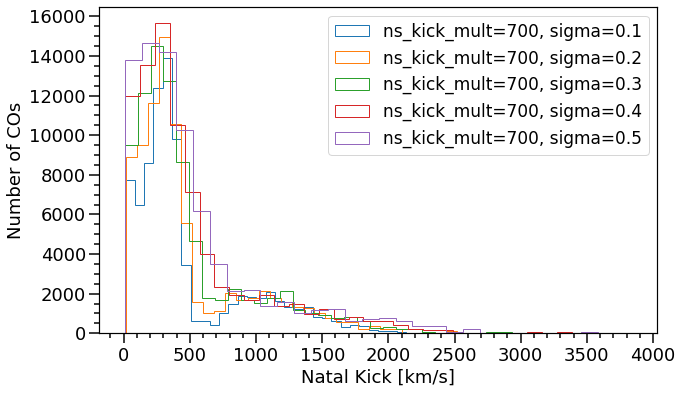

In [8]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

PLOT_RANGE = kick_models["NS_700_RANGE"]
# PLOT_RANGE = np.intersect1d(kick_models["NS_300_RANGE"], kick_models["SIGMA_0.3_RANGE"])
# PLOT_RANGE = kick_models["ALL"]

for i in PLOT_RANGE:
    plt.hist(SN_KICK_NS_ALL[i], bins=30, label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}', histtype='step');

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='Number of COs')
plt.legend(fontsize=17)
plt.show()

In [9]:
def plot_kde(PLOT_RANGE):
    f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
    
    for i in PLOT_RANGE:
        kde_NS = gaussian_kde( SN_KICK_NS_ALL[i] )
        NS_dist_space = linspace( min(SN_KICK_NS_ALL[i]), max(SN_KICK_NS_ALL[i]), 300 )

        plt.plot( NS_dist_space, kde_NS(NS_dist_space), label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)
    plt.show()


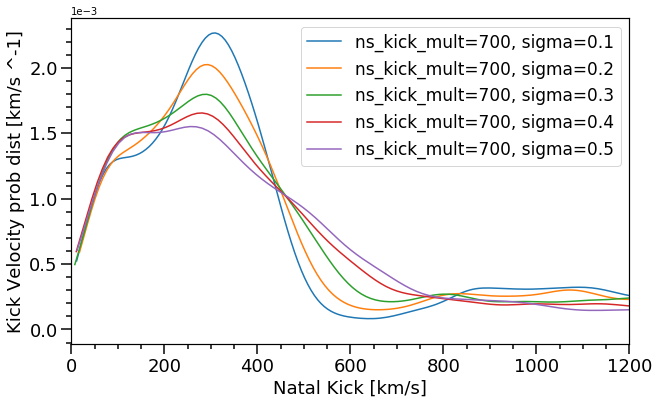

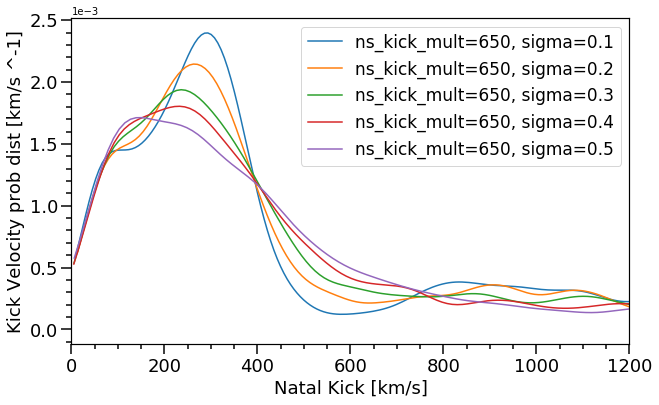

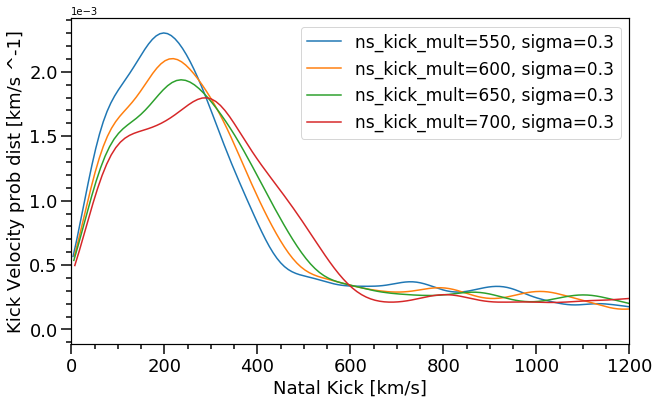

In [10]:
plot_kde(kick_models["NS_700_RANGE"])
plot_kde(kick_models["NS_650_RANGE"])
plot_kde(kick_models["SIGMA_0.3_RANGE"])

# Investigate the difference between SSE and BSE kicks

## BSE Data

In [4]:
path = os.environ['WORK']+'/supernova_remnant_bse/bh_200_ns_400_sigma_0.4_combined.h5'
fdata_bse = h5.File(path, 'r')
list(fdata_bse.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_System_Parameters',
 'Run_Details']

In [5]:
BSE_SN_MASS_CORE = fdata_bse['BSE_Supernovae']["Mass_Core@CO(SN)"][...].squeeze()
BSE_SN_MASS_CO = fdata_bse['BSE_Supernovae']["Mass_CO_Core@CO(SN)"][...].squeeze()

BSE_SN_MASS_REM = fdata_bse['BSE_Supernovae']["Mass(SN)"][...].squeeze()
BSE_SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
BSE_SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

BSE_SN_STELLAR_TYPE_PREV = fdata_bse['BSE_Supernovae']["Stellar_Type_Prev(SN)"][...].squeeze()


BSE_UNBOUND  = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 

BSE_CP_STELLAR_TYPE =fdata_bse['BSE_Supernovae']["Stellar_Type(CP)"][...].squeeze()

# BSE_SN_KICK = fdata_bse['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][...].squeeze()
BSE_SN_KICK = fdata_bse['BSE_Supernovae']["ComponentSpeed(SN)"][...].squeeze()

fdata_bse.close()

In [6]:
BSE_maskSN_NS = ((BSE_SN_STELLAR_TYPE ==13) * (BSE_SN_TYPE == 1)) * (BSE_UNBOUND == 1) # select unbound NSs, ignore electron capture SN
BSE_maskSN_BH = ((BSE_SN_STELLAR_TYPE ==14) * (BSE_SN_TYPE == 1)) * (BSE_UNBOUND == 1) # select unbound BHs, ignore electron capture SN

BSE_maskCP_NS = (BSE_CP_STELLAR_TYPE == 13)
BSE_maskCP_BH = (BSE_CP_STELLAR_TYPE == 14)
BSE_maskCP_other = (BSE_CP_STELLAR_TYPE != 13) * (BSE_CP_STELLAR_TYPE != 14)

## SSE Data

In [7]:
path = os.environ['WORK']+'/supernova_remnant_production/bh_200_ns_400_sigma_0.4_combined.h5'
fdata_sse = h5.File(path, 'r')
list(fdata_sse.keys())

['Run_Details', 'SSE_Supernovae', 'SSE_System_Parameters']

In [8]:
SSE_SN_MASS_CORE = fdata_sse['SSE_Supernovae']["Mass_Core@CO"][...].squeeze()
SSE_SN_MASS_CO = fdata_sse['SSE_Supernovae']["Mass_CO_Core@CO"][...].squeeze()

SSE_SN_MASS_REM = fdata_sse['SSE_Supernovae']["Mass"][...].squeeze()
SSE_SN_STELLAR_TYPE = fdata_sse['SSE_Supernovae']["Stellar_Type"][...].squeeze()
SSE_SN_TYPE = fdata_sse['SSE_Supernovae']["SN_Type"][...].squeeze() 

SSE_SN_STELLAR_TYPE_PREV = fdata_sse['SSE_Supernovae']["Stellar_Type_Prev"][...].squeeze()

SSE_CP_STELLAR_TYPE =fdata_sse['SSE_Supernovae']["Stellar_Type"][...].squeeze()

SSE_SN_KICK = fdata_sse['SSE_Supernovae']["Applied_Kick_Magnitude"][...].squeeze()

fdata_sse.close()

In [9]:
SSE_maskSN_NS = ((SSE_SN_STELLAR_TYPE ==13) * (SSE_SN_TYPE == 1)) # select NSs, ignore electron capture SN
SSE_maskSN_BH = ((SSE_SN_STELLAR_TYPE ==14) * (SSE_SN_TYPE == 1)) # select BHs, ignore electron capture SN

SSE_maskCP_NS = (SSE_CP_STELLAR_TYPE == 13)
SSE_maskCP_BH = (SSE_CP_STELLAR_TYPE == 14)
SSE_maskCP_other = (SSE_CP_STELLAR_TYPE != 13) * (SSE_CP_STELLAR_TYPE != 14)

## Confirm the double peak structure of BSE

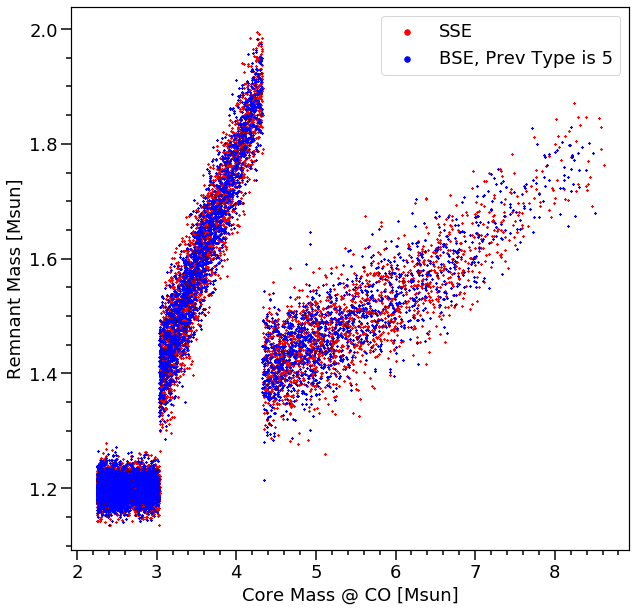

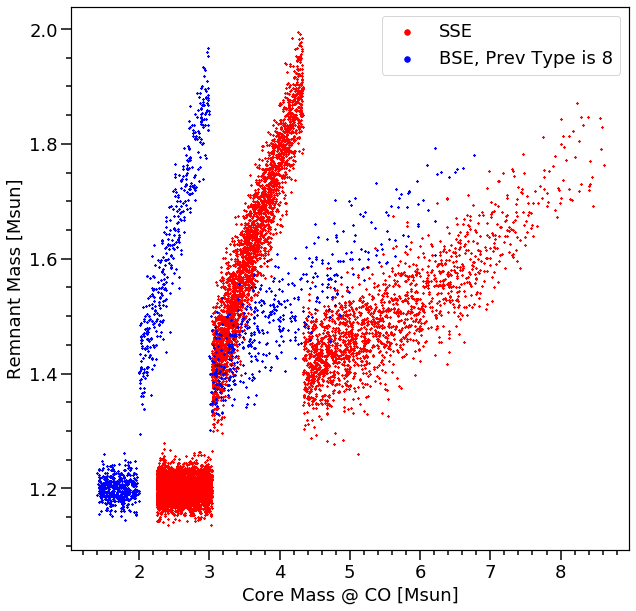

In [12]:
for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)
    f, ax= plt.subplots(1, 1,  figsize=(10,10)) 
    s=0.2
    
    plt.scatter(SSE_SN_MASS_CORE[SSE_maskSN_NS], SSE_SN_MASS_REM[SSE_maskSN_NS], s=s, color='r', label='SSE')

    
    plt.scatter(BSE_SN_MASS_CORE[BSE_maskSN_NS*BSE_maskPrev], BSE_SN_MASS_REM[BSE_maskSN_NS*BSE_maskPrev], s=s, color='b', label=f'BSE, Prev Type is {i}')

    layoutAxes(ax=ax, nameX='Core Mass @ CO [Msun]',\
               nameY='Remnant Mass [Msun]')

    lgnd = plt.legend(scatterpoints=1, fontsize=18)
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]

    plt.show()

It looks like the SSE scenario is identical in mass to the scenario where BSE stars are in the EAGB before supernova. 

In [13]:
for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)
    n_sn = np.sum(BSE_maskSN_NS*BSE_maskPrev)
    n_tot = np.sum(BSE_maskSN_NS)
    print(f"Type {i}: {n_sn} (~{100*(n_sn/n_tot):.2f}%)")
    


Type 5: 237441 (~81.68%)
Type 8: 53240 (~18.32%)


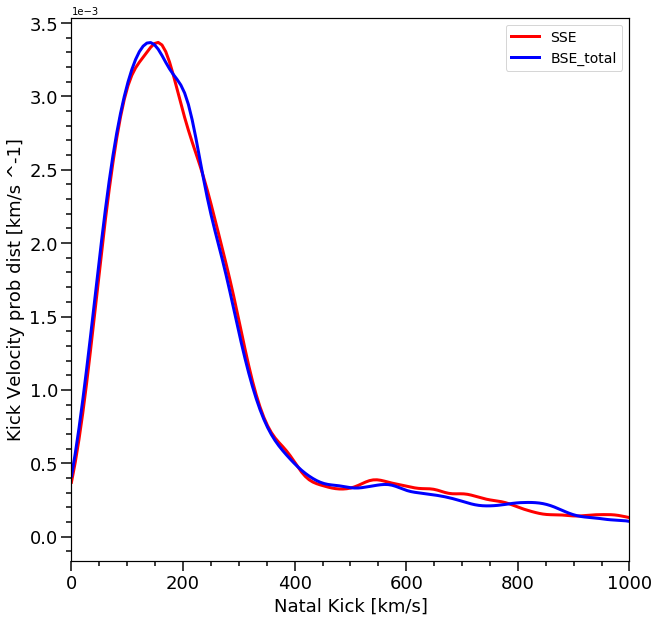

In [14]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


kde_dist_space = linspace( min(BSE_SN_KICK), max(BSE_SN_KICK), 300 )

kde_SSE = gaussian_kde( SSE_SN_KICK[SSE_maskSN_NS] )

kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS] )
kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*(BSE_SN_STELLAR_TYPE_PREV==(5 or 8)) ] )



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, kde_SSE(kde_dist_space), c='r', lw=3, label='SSE')
plt.plot( kde_dist_space, kde_BSE_total(kde_dist_space), c='b', lw=3, label='BSE_total')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.show()

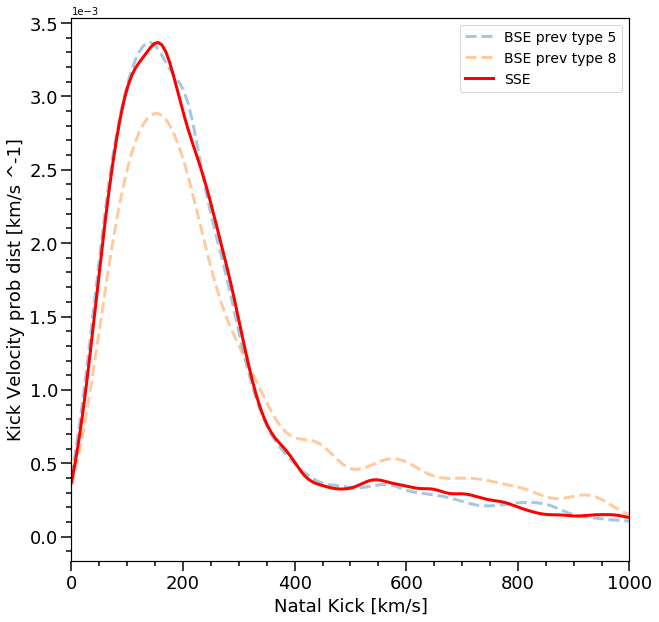

In [16]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)    
    kde_BSE = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*BSE_maskPrev] )
    
    kde_dist_space = linspace( min(BSE_SN_KICK), max(BSE_SN_KICK), 300 )

    plt.plot( kde_dist_space, kde_BSE(kde_dist_space), '--', lw=3, alpha=0.4, label=f'BSE prev type {i}')

kde_SSE = gaussian_kde( SSE_SN_KICK[SSE_maskSN_NS] )

# kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS] )
kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*(BSE_SN_STELLAR_TYPE_PREV==(5 or 8)) ] )



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, kde_SSE(kde_dist_space), c='r', lw=3, label='SSE')
# plt.plot( kde_dist_space, kde_BSE_total(kde_dist_space), c='b', lw=3, label='BSE_total')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.show()

Evidently, both cases produce velocity peaks that are slightly to the left of the SSE case, so this double peak quirk cannot explain why BSE velocities differ slightly from SSE velocities.
My current theory is that (as Ilya suggested) BSE just acts to increase the $\sigma_{ns}$ parameter because it adds some stochastic variation to the velocities around the SSE values. Therefore, the BSE curve has its peak shifted to the left, and tail shifted to the right, which is the behavior we see when we hold $v_{ns}$ constant and increase $\sigma_{ns}$.

# Investigate the ECSN Peak

In [4]:
kick_types = ['ComponentSpeed(SN)', 'Applied_Kick_Magnitude(SN)']

kick_type = kick_types[1]
vns = 550
sigma = 0.3
path = os.environ['WORK']+f'/supernova_remnant_bse/bh_200_ns_{vns}_sigma_{sigma}_ECSN_ABSENT_combined.h5'

In [5]:
fdata_bse = h5.File(path, 'r')
list(fdata_bse.keys())

BSE_SN_MASS_CORE = fdata_bse['BSE_Supernovae']["Mass_Core@CO(SN)"][...].squeeze()
BSE_SN_MASS_CO = fdata_bse['BSE_Supernovae']["Mass_CO_Core@CO(SN)"][...].squeeze()

BSE_SN_MASS_REM = fdata_bse['BSE_Supernovae']["Mass(SN)"][...].squeeze()
BSE_SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
BSE_SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

BSE_UNBOUND  = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 


KICK_DATA = fdata_bse['BSE_Supernovae'][kick_type][...].squeeze()
# BSE_SN_COMP_KICK = fdata_bse['BSE_Supernovae']["ComponentSpeed(SN)"][...].squeeze()

fdata_bse.close()

In [6]:
BSE_mask_CCSN_UNBOUND = ((BSE_SN_STELLAR_TYPE ==13) * (BSE_SN_TYPE == 1)) * (BSE_UNBOUND == 1) # select unbound NSs, ignore electron capture SN
BSE_mask_ALLSN_UNBOUND = ((BSE_SN_STELLAR_TYPE ==13)) * (BSE_UNBOUND == 1) # select unbound NSs, ignore electron capture SN

BSE_mask_CCSN_NS = ((BSE_SN_STELLAR_TYPE ==13) * (BSE_SN_TYPE == 1))  # select unbound NSs, ignore electron capture SN
BSE_mask_ALLSN_NS = ((BSE_SN_STELLAR_TYPE ==13)) # select unbound NSs, ignore electron capture SN

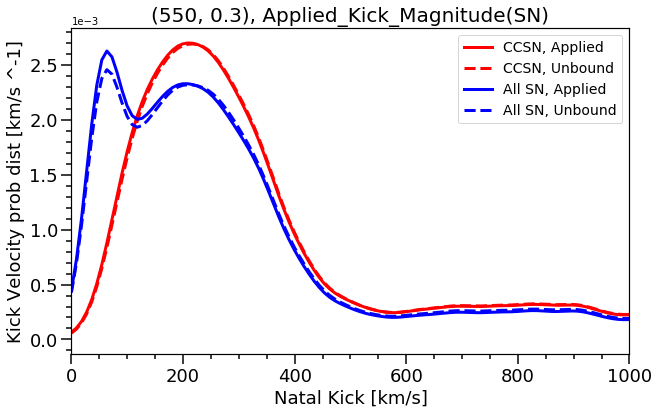

In [7]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 



kde_dist_space = linspace( min(KICK_DATA), max(KICK_DATA), 300 )

kde_CCSN_NS = gaussian_kde( KICK_DATA[BSE_mask_CCSN_NS] )
kde_CCSN_UNBOUND = gaussian_kde( KICK_DATA[BSE_mask_CCSN_UNBOUND] )

kde_ALLSN_NS = gaussian_kde( KICK_DATA[BSE_mask_ALLSN_NS] )
kde_ALLSN_UNBOUND = gaussian_kde( KICK_DATA[BSE_mask_ALLSN_UNBOUND] )



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, kde_CCSN_NS(kde_dist_space), c='r', linestyle='-', lw=3, label='CCSN, Applied')
plt.plot( kde_dist_space, kde_CCSN_UNBOUND(kde_dist_space), c='r', linestyle='--', lw=3, label='CCSN, Unbound')


plt.plot( kde_dist_space, kde_ALLSN_NS(kde_dist_space), c='b', linestyle='-', lw=3, label='All SN, Applied')
plt.plot( kde_dist_space, kde_ALLSN_UNBOUND(kde_dist_space), c='b', linestyle='--', lw=3, label='All SN, Unbound')



plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.title(f'({vns}, {sigma}), {kick_type}', fontsize=20)

plt.show()

# Investigate if changing ECSN simulation makes a difference

In [71]:
kick_types = ['ComponentSpeed(SN)', 'Applied_Kick_Magnitude(SN)']

kick_type = kick_types[1]
vns = 550
sigma = 0.3
# path = os.environ['WORK']+f'/supernova_remnant_bse/bh_200_ns_{vns}_sigma_{sigma}_ECSN_ABSENT_combined.h5'
path = os.environ['WORK']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'

In [7]:
fdata_bse = h5.File(path, 'r')

SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

UNBOUND  = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 

KICK_DATA = fdata_bse['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
COMPONENT_SPEEDS = fdata_bse['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()

fdata_bse.close()

In [8]:
CCSN_UNBOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 1)) * (UNBOUND == 1)]
CCSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 1)) * (UNBOUND == 0)]
CCSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 1))] 

ECSN_UNBOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2)) * (UNBOUND == 1)]
ECSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2)) * (UNBOUND == 0)]
ECSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2))] 


ALLSN_UNBOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 1)] 
ALLSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 0)] 
ALLSN = KICK_DATA[((SN_STELLAR_TYPE ==13))] 

In [9]:
print(len(ECSN))

26800


## --allow-H-rich-ECSN FALSE

In [69]:
# path_ECSN = os.environ['WORK']+f'/supernova_remnant_bse/bh_200_ns_{vns}_sigma_{sigma}_ECSN_combined.h5'
path_ECSN = os.environ['WORK']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'

In [70]:
fdata_bse_ECSN = h5.File(path_ECSN, 'r')

SEED_ECSN = fdata_bse_ECSN['BSE_Supernovae']["SEED"][...].squeeze()
SN_STELLAR_TYPE_ECSN = fdata_bse_ECSN['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
SN_TYPE_ECSN = fdata_bse_ECSN['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

UNBOUND_ECSN  = fdata_bse_ECSN['BSE_Supernovae']["Unbound"][...].squeeze() 

KICK_DATA_ECSN = fdata_bse_ECSN['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
COMPONENT_SPEEDS_ECSN = fdata_bse_ECSN['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()

MT_DONOR_HIST = fdata_bse_ECSN['BSE_Supernovae']["MT_Donor_Hist(SN)"][...].squeeze()
MT_DONOR_HIST = list(map(lambda x: x.decode('utf-8'), MT_DONOR_HIST))
MT_DONOR_MASK = np.full(len(MT_DONOR_HIST), True, dtype="bool")

indices = []
for i in range(len(MT_DONOR_HIST)):
    if SN_TYPE_ECSN[i]==2:
        MT_DONOR_MASK[i] = bool("NA" not in MT_DONOR_HIST[i])
        if ("NA" in MT_DONOR_HIST[i]):
            indices.append(i)
            print("found accretor progenitor")
            
fdata_bse_ECSN.close()

In [13]:
CCSN_UNBOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 1)) * (UNBOUND_ECSN == 1) * (MT_DONOR_MASK)]
CCSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 1)) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)]
CCSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 1)) * (MT_DONOR_MASK)] 

ECSN_UNBOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 2)) * (UNBOUND_ECSN == 1) * (MT_DONOR_MASK)]
ECSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 2)) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)]
ECSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN == 2)) * (MT_DONOR_MASK)] 

ALLSN_UNBOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 1) * (MT_DONOR_MASK)] 
ALLSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)] 
ALLSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (MT_DONOR_MASK)] 

In [14]:
print(len(ECSN_ECSN_FALSE))

11840


In [86]:
# fdata_bse_ECSN = h5.File(path_ECSN, 'r')

# MT_RLOF = fdata_bse_ECSN['BSE_RLOF']["MT_Event_Counter"][...].squeeze()
# SEED_RLOF = fdata_bse_ECSN['BSE_RLOF']["SEED"][...].squeeze()
# print(fdata_bse_ECSN['BSE_RLOF'].keys())
# fdata_bse_ECSN.close()

In [87]:
# data_RLOF = {'MT_RLOF': MT_RLOF}
 
# # Creates pandas DataFrame.
# df_RLOF = pd.DataFrame(data_RLOF, index=SEED_RLOF)
# df_RLOF = df_RLOF[df_RLOF['MT_RLOF'] > 1]

# print(df_RLOF.shape)
# # df_RLOF.head()

In [88]:
# fdata_bse_ECSN = h5.File(path_ECSN, 'r')

# RLOF = fdata_bse_ECSN['BSE_Supernovae']["MT_Donor_Hist(SN)"][...].squeeze()

# print(fdata_bse_ECSN['BSE_Supernovae'].keys())

# print()

# # NAbyte = RLOF[0].decode('UTF-8')
# data = RLOF.astype(str)

# donors = 0
# for rlof in data:
#     if not 'NA' in rlof:
#         donors = donors+1

# print(f"{donors} donors out of {len(RLOF)} events")

# fdata_bse_ECSN.close()

In [89]:
# data_ecsn_false = {'SN_STELLAR_TYPE_ECSN': SN_STELLAR_TYPE_ECSN ,
#                    'SN_TYPE_ECSN': SN_TYPE_ECSN,
#                    'UNBOUND_ECSN': UNBOUND_ECSN,
#                    'KICK_DATA_ECSN': KICK_DATA_ECSN,
#                    'COMPONENT_SPEEDS_ECSN': COMPONENT_SPEEDS_ECSN,
#                    'MT_DONOR_HIST': MT_DONOR_HIST}
 
# # Creates pandas DataFrame.
# df_ecsn_false = pd.DataFrame(data_ecsn_false, index=SEED_ECSN)
# print(df_ecsn_false.shape)
# # df_ecsn_false.head()

In [90]:
# mask_RLOF_to_ECSN = np.in1d(SEED_ECSN, SEED_RLOF)
# len(mask_RLOF_to_ECSN)

In [91]:
# df_ecsn_false_only = df_ecsn_false
# df_ecsn_false_only = df_ecsn_false.loc[mask_RLOF_to_ECSN]

# df_ecsn_false_only = df_ecsn_false_only[df_ecsn_false_only['SN_STELLAR_TYPE_ECSN'] == 13]
# df_ecsn_false_only = df_ecsn_false_only[~df_ecsn_false_only['MT_DONOR_HIST'].str.contains("NA")]

# print(df_ecsn_false_only.shape)
# df_ecsn_false_only.head()

In [92]:
# CCSN_UNBOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==1) & (df_ecsn_false_only['SN_TYPE_ECSN']==1)]['KICK_DATA_ECSN'].to_numpy()
# CCSN_BOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==0) & (df_ecsn_false_only['SN_TYPE_ECSN']==1)]['KICK_DATA_ECSN'].to_numpy()
# CCSN_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['SN_TYPE_ECSN']==1)]['KICK_DATA_ECSN'].to_numpy()

# ECSN_UNBOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==1) & (df_ecsn_false_only['SN_TYPE_ECSN']==2)]['KICK_DATA_ECSN'].to_numpy()
# ECSN_BOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==0) & (df_ecsn_false_only['SN_TYPE_ECSN']==2)]['KICK_DATA_ECSN'].to_numpy()
# ECSN_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['SN_TYPE_ECSN']==2)]['KICK_DATA_ECSN'].to_numpy()

# ALLSN_UNBOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==1)]['KICK_DATA_ECSN'].to_numpy()
# ALLSN_BOUND_ECSN_FALSE = df_ecsn_false_only[(df_ecsn_false_only['UNBOUND_ECSN']==0) ]['KICK_DATA_ECSN'].to_numpy()
# ALLSN_ECSN_FALSE = df_ecsn_false_only['KICK_DATA_ECSN'].to_numpy()

## --allow-H-rich-ECSN TRUE

In [93]:
path_ECSN_TRUE = os.environ['WORK']+f'/supernova_remnant_bse/bh_200_ns_{vns}_sigma_{sigma}_ECSN_TRUE_combined.h5'

In [94]:
fdata_bse_ECSN_TRUE = h5.File(path_ECSN_TRUE, 'r')

SN_STELLAR_TYPE_ECSN_TRUE = fdata_bse_ECSN_TRUE['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
SN_TYPE_ECSN_TRUE = fdata_bse_ECSN_TRUE['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

UNBOUND_ECSN_TRUE  = fdata_bse_ECSN_TRUE['BSE_Supernovae']["Unbound"][...].squeeze() 

KICK_DATA_ECSN_TRUE = fdata_bse_ECSN_TRUE['BSE_Supernovae'][kick_type][...].squeeze()
fdata_bse_ECSN.close()

In [95]:
CCSN_UNBOUND_ECSN_TRUE = KICK_DATA_ECSN_TRUE[((SN_STELLAR_TYPE_ECSN_TRUE ==13) * (SN_TYPE_ECSN_TRUE == 1)) * (UNBOUND_ECSN_TRUE == 1)]
CCSN_BOUND_ECSN_TRUE = KICK_DATA_ECSN_TRUE[((SN_STELLAR_TYPE_ECSN_TRUE ==13) * (SN_TYPE_ECSN_TRUE == 1)) * (UNBOUND_ECSN_TRUE == 0)]
CCSN_ECSN_TRUE = KICK_DATA_ECSN_TRUE[(SN_STELLAR_TYPE_ECSN_TRUE ==13) * (SN_TYPE_ECSN_TRUE == 1)] 

ALLSN_UNBOUND_ECSN_TRUE = KICK_DATA_ECSN_TRUE[((SN_STELLAR_TYPE_ECSN_TRUE ==13)) * (UNBOUND_ECSN_TRUE == 1)] 
ALLSN_BOUND_ECSN_TRUE = KICK_DATA_ECSN_TRUE[((SN_STELLAR_TYPE_ECSN_TRUE ==13)) * (UNBOUND_ECSN_TRUE == 0)] 
ALLSN_ECSN_TRUE = KICK_DATA_ECSN_TRUE[((SN_STELLAR_TYPE_ECSN_TRUE ==13))] 

## Compare

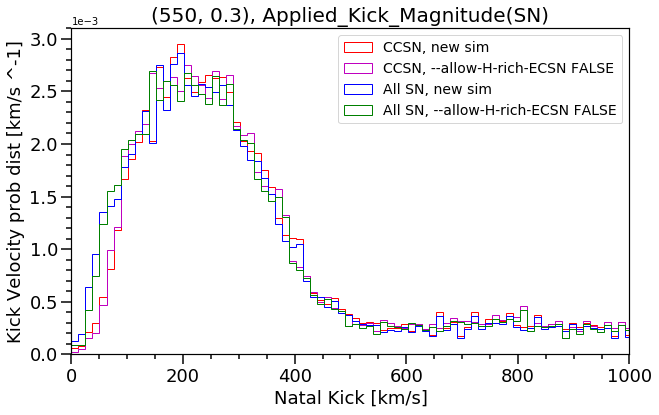

In [15]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

bins = np.linspace(0,2500, 200)

plt.hist(CCSN, bins=bins, color='r', histtype='step', density='True', label='CCSN, new sim')
plt.hist(CCSN_ECSN_FALSE, bins=bins, color='m', histtype='step', density='True', label='CCSN, --allow-H-rich-ECSN FALSE')
# plt.hist(CCSN_ECSN_TRUE, bins=bins, color='brown', histtype='step', density='True', label='CCSN, --allow-H-rich-ECSN TRUE')


plt.hist(ALLSN, bins=bins, color='b', histtype='step', density='True', label='All SN, new sim')
plt.hist(ALLSN_ECSN_FALSE, bins=bins, color='g', histtype='step', density='True', label='All SN, --allow-H-rich-ECSN FALSE')
# plt.hist(ALLSN_ECSN_TRUE, bins=bins, color='k', histtype='step', density='True', label='All SN, --allow-H-rich-ECSN TRUE')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.title(f'({vns}, {sigma}), {kick_type}', fontsize=20)

plt.show()

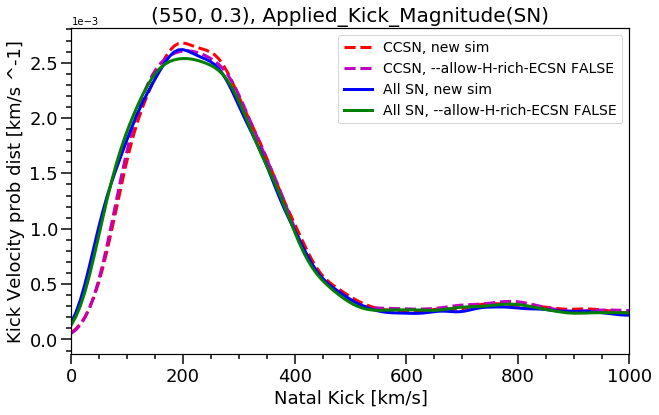

In [16]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 


kde_dist_space = linspace( min(ALLSN), max(ALLSN), 300 )

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')


plt.plot( kde_dist_space, gaussian_kde(CCSN)(kde_dist_space), c='r', linestyle='--', lw=3, label='CCSN, new sim')
plt.plot( kde_dist_space, gaussian_kde(CCSN_ECSN_FALSE)(kde_dist_space), c='m', linestyle='--', lw=3, label='CCSN, --allow-H-rich-ECSN FALSE')
# plt.plot( kde_dist_space, gaussian_kde(CCSN_ECSN_TRUE)(kde_dist_space), c='brown', linestyle='--', lw=3, label='CCSN, --allow-H-rich-ECSN TRUE')


plt.plot( kde_dist_space, gaussian_kde(ALLSN)(kde_dist_space), c='b', linestyle='-', lw=3, label='All SN, new sim')
plt.plot( kde_dist_space, gaussian_kde(ALLSN_ECSN_FALSE)(kde_dist_space), c='g', linestyle='-', lw=3, label='All SN, --allow-H-rich-ECSN FALSE')
# plt.plot( kde_dist_space, gaussian_kde(ALLSN_ECSN_TRUE)(kde_dist_space), c='k', linestyle='-', lw=3, label='All SN, --allow-H-rich-ECSN TRUE')



plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.title(f'({vns}, {sigma}), {kick_type}', fontsize=20)

plt.show()

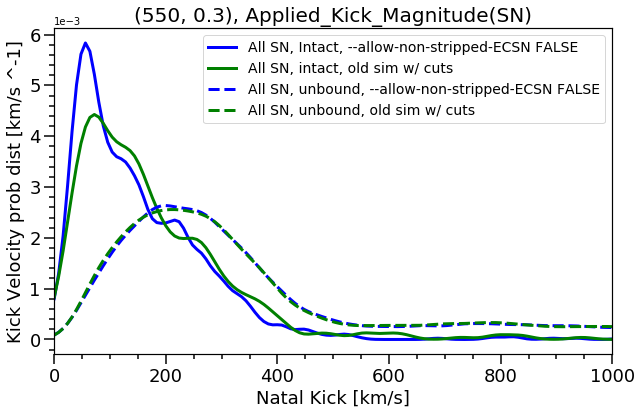

In [17]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 


kde_dist_space = linspace( min(ALLSN), max(ALLSN), 300 )

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, gaussian_kde(ALLSN_BOUND)(kde_dist_space), c='b', linestyle='-', lw=3, label='All SN, Intact, --allow-non-stripped-ECSN FALSE')
plt.plot( kde_dist_space, gaussian_kde(ALLSN_BOUND_ECSN_FALSE)(kde_dist_space), c='g', linestyle='-', lw=3, label='All SN, intact, old sim w/ cuts')

plt.plot( kde_dist_space, gaussian_kde(ALLSN_UNBOUND)(kde_dist_space), c='b', linestyle='--', lw=3, label='All SN, unbound, --allow-non-stripped-ECSN FALSE')
plt.plot( kde_dist_space, gaussian_kde(ALLSN_UNBOUND_ECSN_FALSE)(kde_dist_space), c='g', linestyle='--', lw=3, label='All SN, unbound, old sim w/ cuts')



plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.title(f'({vns}, {sigma}), {kick_type}', fontsize=20)

plt.show()

## Bootstrapping test

In [99]:
boot1 = CCSN_ECSN_FALSE
boot2 =  np.random.choice(CCSN_ECSN_FALSE, len(CCSN_ECSN_FALSE))
boot3 =  np.random.choice(CCSN_ECSN_FALSE, len(CCSN_ECSN_FALSE))

In [100]:
boot11 = CCSN_ECSN_TRUE
boot12 =  np.random.choice(CCSN_ECSN_TRUE, len(CCSN_ECSN_TRUE))
boot13 =  np.random.choice(CCSN_ECSN_TRUE, len(CCSN_ECSN_TRUE))

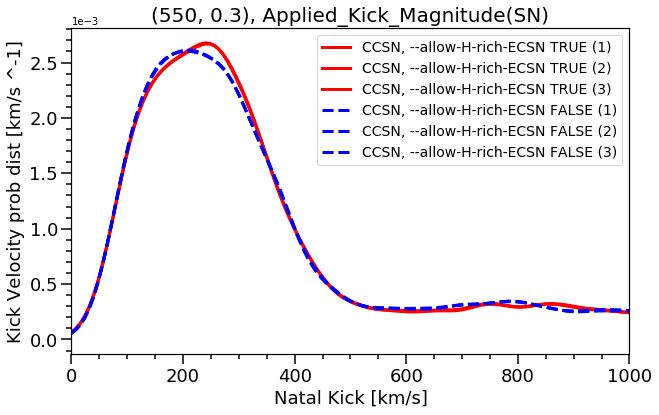

In [101]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 


kde_dist_space = linspace( min(ALLSN), max(ALLSN), 300 )

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')


plt.plot( kde_dist_space, gaussian_kde(boot11)(kde_dist_space), c='r', linestyle='-', lw=3, label='CCSN, --allow-H-rich-ECSN TRUE (1)')
plt.plot( kde_dist_space, gaussian_kde(boot12)(kde_dist_space), c='r', linestyle='-', lw=3, label='CCSN, --allow-H-rich-ECSN TRUE (2)')
plt.plot( kde_dist_space, gaussian_kde(boot13)(kde_dist_space), c='r', linestyle='-', lw=3, label='CCSN, --allow-H-rich-ECSN TRUE (3)')


plt.plot( kde_dist_space, gaussian_kde(boot1)(kde_dist_space), c='b', linestyle='--', lw=3, label='CCSN, --allow-H-rich-ECSN FALSE (1)')
plt.plot( kde_dist_space, gaussian_kde(boot2)(kde_dist_space), c='b', linestyle='--', lw=3, label='CCSN, --allow-H-rich-ECSN FALSE (2)')
plt.plot( kde_dist_space, gaussian_kde(boot3)(kde_dist_space), c='b', linestyle='--', lw=3, label='CCSN, --allow-H-rich-ECSN FALSE (3)')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.title(f'({vns}, {sigma}), {kick_type}', fontsize=20)

plt.show()

# Investigate Difference b/w Applied Kicks and Component Speeds

## Old simulation with Cuts

In [18]:
print("Total Number of NS Binaries (--allow-H-rich-ECSN FALSE):", len(ALLSN_ECSN_FALSE))
print(f"Intact Binaries : {len(ALLSN_BOUND_ECSN_FALSE)} ({len(ALLSN_BOUND_ECSN_FALSE)/len(ALLSN_ECSN_FALSE)*100:.1f}%)")
print(f"Disrupted Binaries : {len(ALLSN_UNBOUND_ECSN_FALSE)} ({len(ALLSN_UNBOUND_ECSN_FALSE)/len(ALLSN_ECSN_FALSE)*100:.1f}%)")

Total Number of NS Binaries (--allow-H-rich-ECSN FALSE): 339160
Intact Binaries : 19560 (5.8%)
Disrupted Binaries : 319600 (94.2%)


In [19]:
print("Total Number of ECSN events:", len(ECSN_ECSN_FALSE))
print(f"Intact Binaries after ECSN: {len(ECSN_BOUND_ECSN_FALSE)} ({len(ECSN_BOUND_ECSN_FALSE)/len(ECSN_ECSN_FALSE)*100:.1f}%)")
print(f"Disrupted Binaries after ECSN: {len(ECSN_UNBOUND_ECSN_FALSE)} ({len(ECSN_UNBOUND_ECSN_FALSE)/len(ECSN_ECSN_FALSE)*100:.1f}%)")

Total Number of ECSN events: 11840
Intact Binaries after ECSN: 3920 (33.1%)
Disrupted Binaries after ECSN: 7920 (66.9%)


In [20]:
APPLIED_KICKS_ALLSN_UNBOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 1) * (MT_DONOR_MASK)] 
APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)] 
APPLIED_KICKS_ALLSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (MT_DONOR_MASK)] 

APPLIED_KICKS_ECSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (SN_TYPE_ECSN==2) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)] 
APPLIED_KICKS_ECSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN==2) * (MT_DONOR_MASK))] 

APPLIED_KICKS_CCSN_BOUND_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (SN_TYPE_ECSN==1) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)] 
APPLIED_KICKS_CCSN_ECSN_FALSE = KICK_DATA_ECSN[((SN_STELLAR_TYPE_ECSN ==13) * (SN_TYPE_ECSN==1) * (MT_DONOR_MASK))] 


CP_SPEEDS_ALLSN_UNBOUND_ECSN_FALSE = COMPONENT_SPEEDS_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 1) * (MT_DONOR_MASK)] 
CP_SPEEDS_ALLSN_BOUND_ECSN_FALSE = COMPONENT_SPEEDS_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (UNBOUND_ECSN == 0) * (MT_DONOR_MASK)] 
CP_SPEEDS_ALLSN_ECSN_FALSE = COMPONENT_SPEEDS_ECSN[((SN_STELLAR_TYPE_ECSN ==13)) * (MT_DONOR_MASK)] 

In [21]:
# number of intact binaries with componentspeeds higher than kicks
print(f"{sum(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE < CP_SPEEDS_ALLSN_BOUND_ECSN_FALSE)} out of {len(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE)} \
({100* sum(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE < CP_SPEEDS_ALLSN_BOUND_ECSN_FALSE)/len(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE):.2f}%)") 


440 out of 19560 (2.25%)


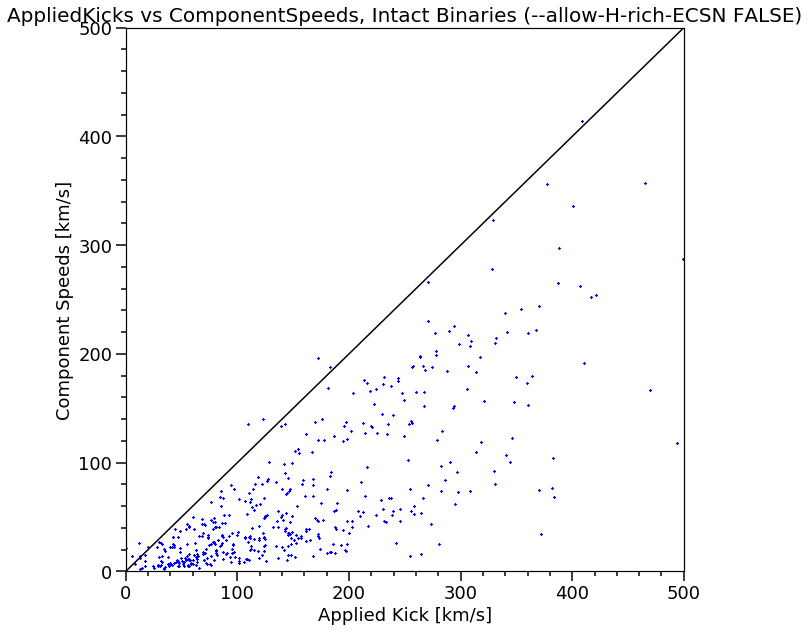

In [22]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Component Speeds [km/s]')

size=0.2

plt.scatter( APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE, CP_SPEEDS_ALLSN_BOUND_ECSN_FALSE, s=size, c='b', label='Intact')
x = np.linspace(0,1000, 1000)
plt.plot(x,x, 'k-')


plt.xlim(0,500)
plt.ylim(0,500)

plt.title("AppliedKicks vs ComponentSpeeds, Intact Binaries (--allow-H-rich-ECSN FALSE)", fontsize=20)

plt.show()

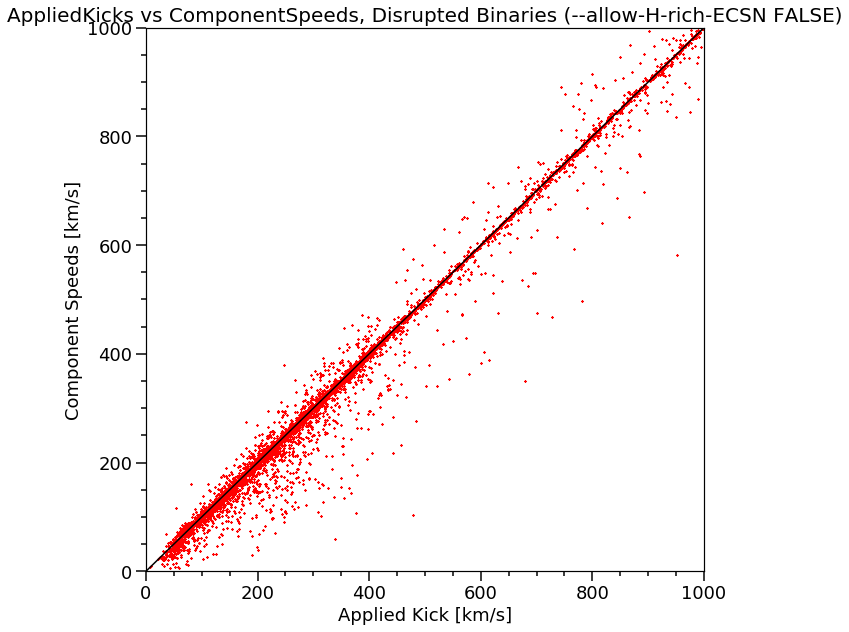

In [23]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Component Speeds [km/s]')

size=0.2
plt.scatter( APPLIED_KICKS_ALLSN_UNBOUND_ECSN_FALSE, CP_SPEEDS_ALLSN_UNBOUND_ECSN_FALSE, s=size, c='r', label='Disrupted')

x = np.linspace(0,2000, 2000)
plt.plot(x,x, 'k-')

plt.xlim(0,1000)
plt.ylim(0,1000)

plt.title("AppliedKicks vs ComponentSpeeds, Disrupted Binaries (--allow-H-rich-ECSN FALSE)", fontsize=20)

plt.show()

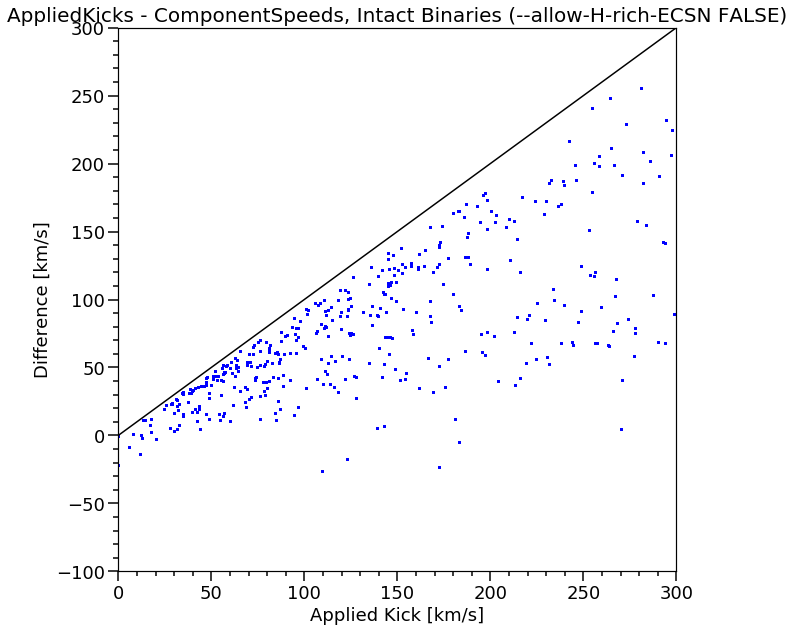

In [24]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Difference [km/s]')

size=1

plt.scatter( APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE, APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE - CP_SPEEDS_ALLSN_BOUND_ECSN_FALSE, s=size, c='b', label='Intact')
x = np.linspace(-2000, 2000, 2000)
plt.plot(x,x, 'k-')

plt.title("AppliedKicks - ComponentSpeeds, Intact Binaries (--allow-H-rich-ECSN FALSE)", fontsize=20)

plt.xlim(0,300)
plt.ylim(-100,300)

plt.show()

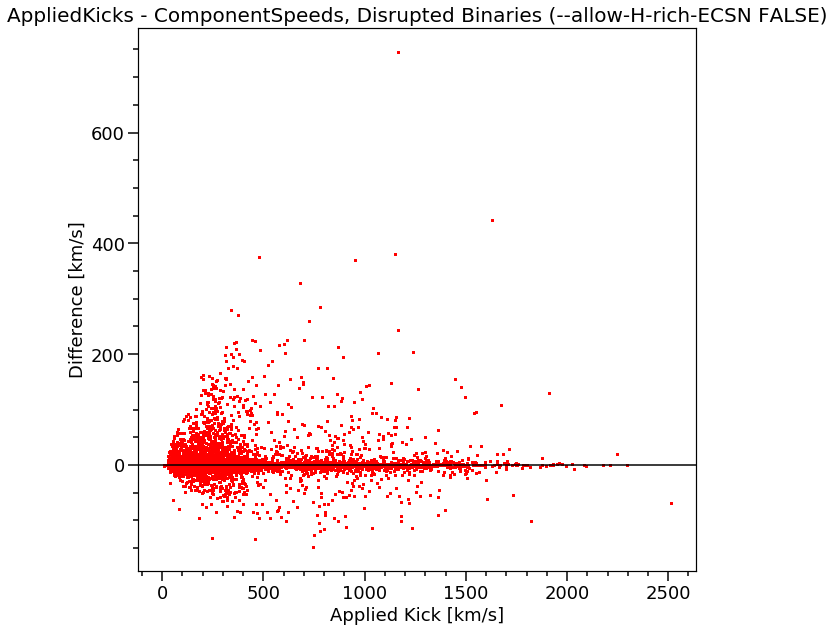

In [25]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 



layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Difference [km/s]')

size=1


plt.scatter( APPLIED_KICKS_ALLSN_UNBOUND_ECSN_FALSE, APPLIED_KICKS_ALLSN_UNBOUND_ECSN_FALSE - CP_SPEEDS_ALLSN_UNBOUND_ECSN_FALSE, s=size, c='r', label='Disrupted')
plt.axhline(y=0, color='k')

plt.title("AppliedKicks - ComponentSpeeds, Disrupted Binaries (--allow-H-rich-ECSN FALSE)", fontsize=20)


plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


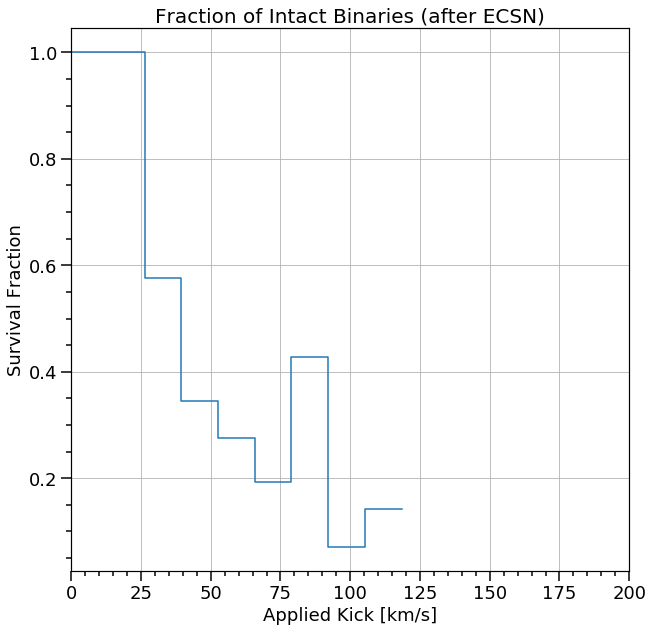

In [26]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 250, 20)

survived, bins = np.histogram(APPLIED_KICKS_ECSN_BOUND_ECSN_FALSE, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_ECSN_ECSN_FALSE, bins=bins)

plt.step(bins[:-1], survived/total, where='post')


plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (after ECSN)", fontsize=20)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


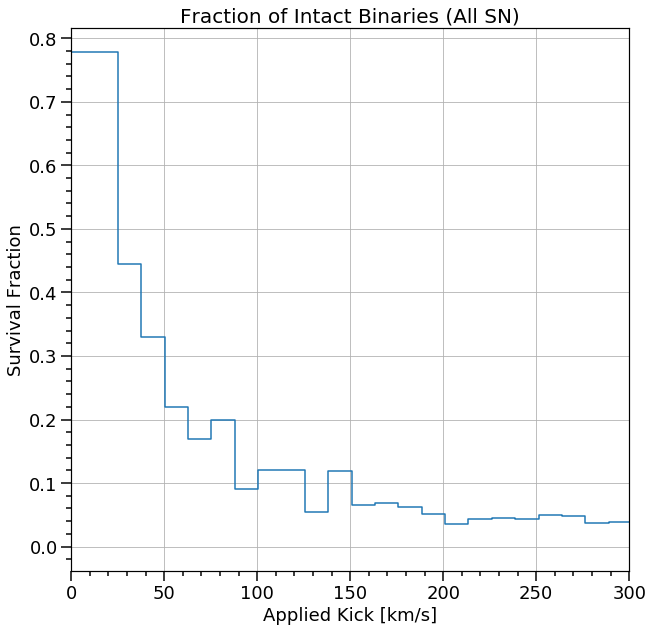

In [27]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 2500, 200)

survived, bins = np.histogram(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_ALLSN_ECSN_FALSE, bins=bins)

plt.step(bins[:-1], survived/total, where='post')


plt.xlim(0,300)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (All SN)", fontsize=20)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


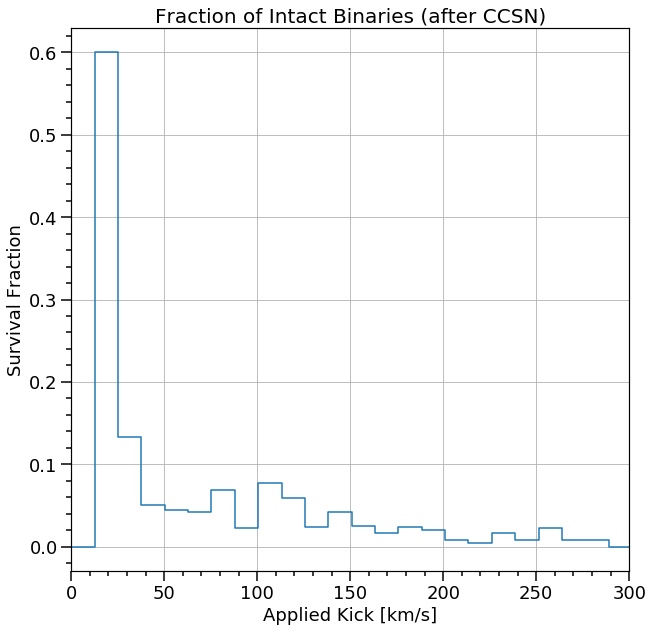

In [28]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 2500, 200)

survived, bins = np.histogram(APPLIED_KICKS_CCSN_BOUND_ECSN_FALSE, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_CCSN_ECSN_FALSE, bins=bins)

plt.step(bins[:-1], survived/total, where='post')


plt.xlim(0,300)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (after CCSN)", fontsize=20)

plt.grid()
plt.show()

## New Simulation

In [29]:
print("Total Number of NS Binaries (--allow-non-stripped-ECSN FALSE):", len(ALLSN))
print(f"Intact Binaries : {len(ALLSN_BOUND)} ({len(ALLSN_BOUND)/len(ALLSN)*100:.1f}%)")
print(f"Disrupted Binaries : {len(ALLSN_UNBOUND)} ({len(ALLSN_UNBOUND)/len(ALLSN)*100:.1f}%)")

Total Number of NS Binaries (--allow-non-stripped-ECSN FALSE): 679956
Intact Binaries : 45400 (6.7%)
Disrupted Binaries : 634556 (93.3%)


In [30]:
print("Total Number of ECSN events:", len(ECSN))
print(f"Intact Binaries after ECSN: {len(ECSN_BOUND)} ({len(ECSN_BOUND)/len(ECSN)*100:.1f}%)")
print(f"Disrupted Binaries after ECSN: {len(ECSN_UNBOUND)} ({len(ECSN_UNBOUND)/len(ECSN)*100:.1f}%)")

Total Number of ECSN events: 26800
Intact Binaries after ECSN: 12480 (46.6%)
Disrupted Binaries after ECSN: 14320 (53.4%)


In [31]:
APPLIED_KICKS_ALLSN_UNBOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 1)] 
APPLIED_KICKS_ALLSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 0)] 
APPLIED_KICKS_ALLSN = KICK_DATA[((SN_STELLAR_TYPE ==13))] 

APPLIED_KICKS_ECSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (SN_TYPE==2) * (UNBOUND == 0)] 
APPLIED_KICKS_ECSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE==2))] 

APPLIED_KICKS_CCSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13)) * (SN_TYPE==1) * (UNBOUND == 0)] 
APPLIED_KICKS_CCSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE==1))] 


CP_SPEEDS_ALLSN_UNBOUND = COMPONENT_SPEEDS[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 1)] 
CP_SPEEDS_ALLSN_BOUND = COMPONENT_SPEEDS[((SN_STELLAR_TYPE ==13)) * (UNBOUND == 0)] 
CP_SPEEDS_ALLSN = COMPONENT_SPEEDS[((SN_STELLAR_TYPE ==13))] 

In [32]:
# number of intact binaries with componentspeeds higher than kicks
print(f"{sum(APPLIED_KICKS_ALLSN_BOUND < CP_SPEEDS_ALLSN_BOUND)} out of {len(APPLIED_KICKS_ALLSN_BOUND)} \
({100* sum(APPLIED_KICKS_ALLSN_BOUND < CP_SPEEDS_ALLSN_BOUND)/len(APPLIED_KICKS_ALLSN_BOUND):.2f}%)") 


1640 out of 45400 (3.61%)


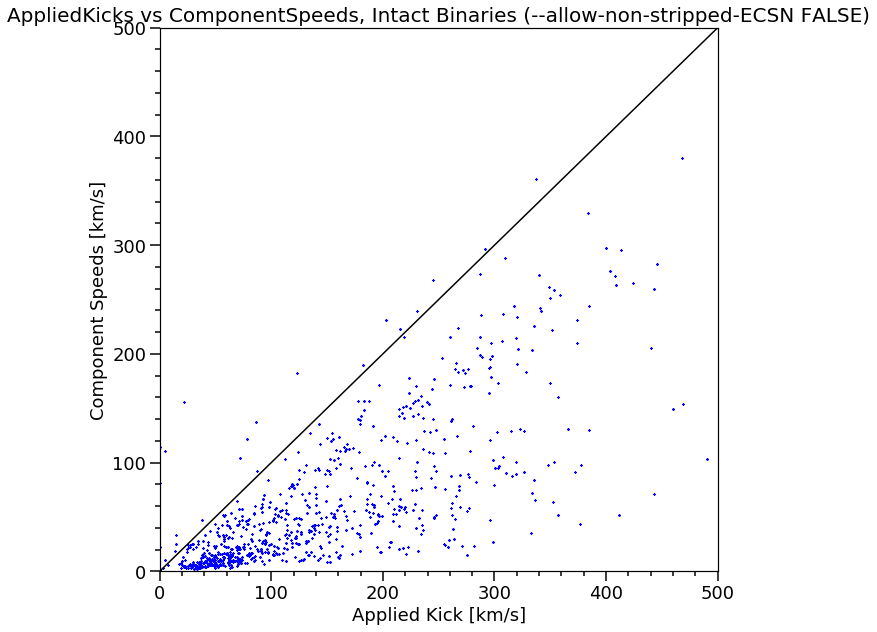

In [33]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Component Speeds [km/s]')

size=0.2

plt.scatter( APPLIED_KICKS_ALLSN_BOUND, CP_SPEEDS_ALLSN_BOUND, s=size, c='b', label='Intact')
x = np.linspace(0,1000, 1000)
plt.plot(x,x, 'k-')


plt.xlim(0,500)
plt.ylim(0,500)

plt.title("AppliedKicks vs ComponentSpeeds, Intact Binaries (--allow-non-stripped-ECSN FALSE)", fontsize=20)

plt.show()

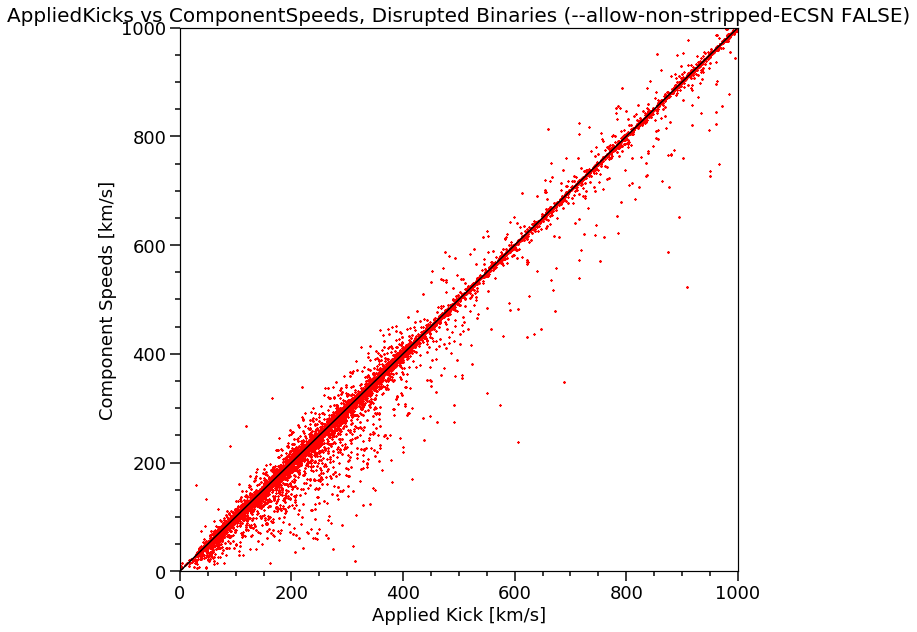

In [34]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Component Speeds [km/s]')

size=0.2
plt.scatter( APPLIED_KICKS_ALLSN_UNBOUND, CP_SPEEDS_ALLSN_UNBOUND, s=size, c='r', label='Disrupted')

x = np.linspace(0,2000, 2000)
plt.plot(x,x, 'k-')

plt.xlim(0,1000)
plt.ylim(0,1000)

plt.title("AppliedKicks vs ComponentSpeeds, Disrupted Binaries (--allow-non-stripped-ECSN FALSE)", fontsize=20)

plt.show()

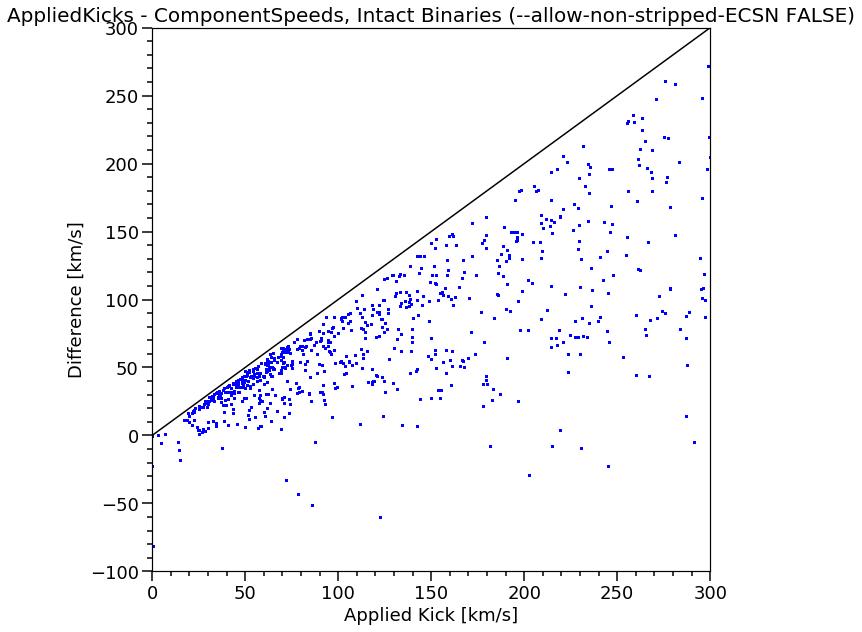

In [35]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Difference [km/s]')

size=1

plt.scatter( APPLIED_KICKS_ALLSN_BOUND, APPLIED_KICKS_ALLSN_BOUND - CP_SPEEDS_ALLSN_BOUND, s=size, c='b', label='Intact')
x = np.linspace(-2000, 2000, 2000)
plt.plot(x,x, 'k-')

plt.title("AppliedKicks - ComponentSpeeds, Intact Binaries (--allow-non-stripped-ECSN FALSE)", fontsize=20)

plt.xlim(0,300)
plt.ylim(-100,300)

plt.show()

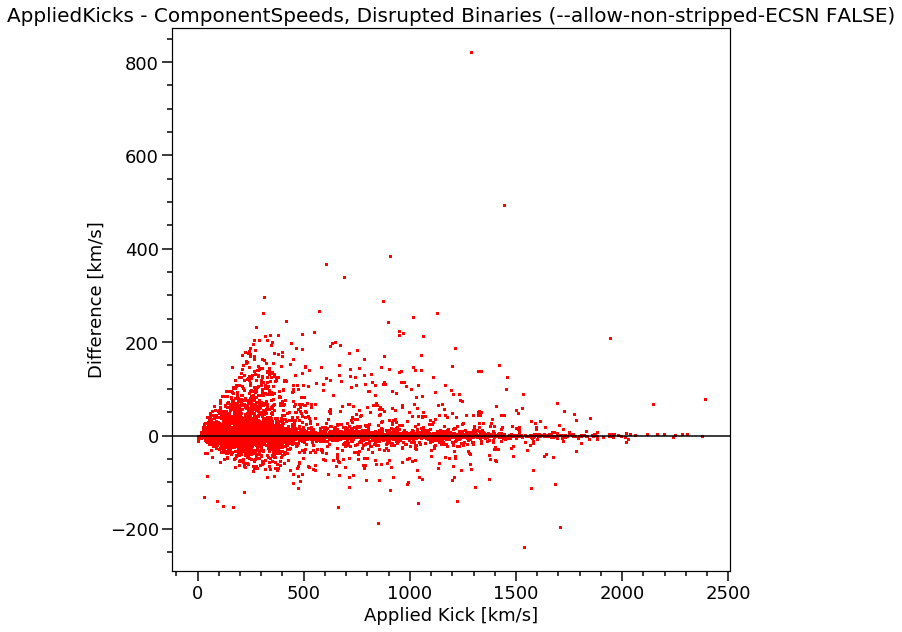

In [36]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 



layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Difference [km/s]')

size=1


plt.scatter( APPLIED_KICKS_ALLSN_UNBOUND, APPLIED_KICKS_ALLSN_UNBOUND - CP_SPEEDS_ALLSN_UNBOUND, s=size, c='r', label='Disrupted')
plt.axhline(y=0, color='k')

plt.title("AppliedKicks - ComponentSpeeds, Disrupted Binaries (--allow-non-stripped-ECSN FALSE)", fontsize=20)


plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


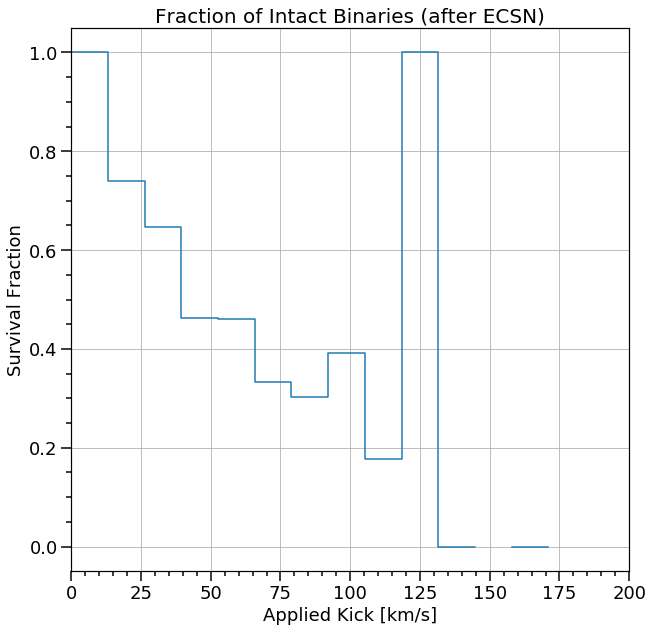

In [37]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 250, 20)

survived, bins = np.histogram(APPLIED_KICKS_ECSN_BOUND, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_ECSN, bins=bins)

plt.step(bins[:-1], (survived/total), where='post')


plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (after ECSN)", fontsize=20)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


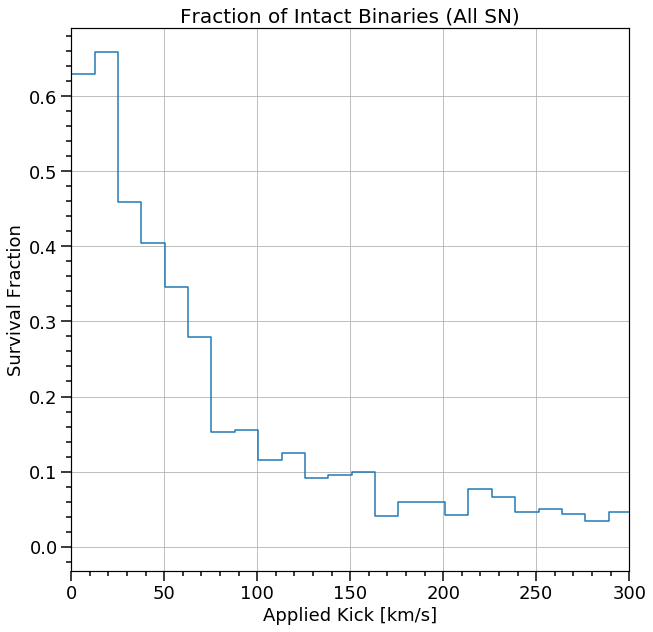

In [38]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 2500, 200)

survived, bins = np.histogram(APPLIED_KICKS_ALLSN_BOUND, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_ALLSN, bins=bins)

plt.step(bins[:-1], survived/total, where='post')


plt.xlim(0,300)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (All SN)", fontsize=20)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


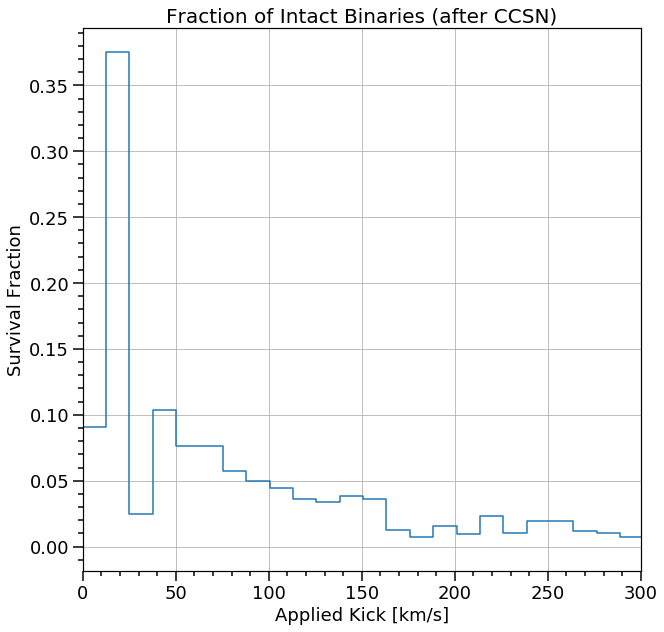

In [39]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 2500, 200)

survived, bins = np.histogram(APPLIED_KICKS_CCSN_BOUND, bins=bins)
total, bins = np.histogram(APPLIED_KICKS_CCSN, bins=bins)

plt.step(bins[:-1], survived/total, where='post')


plt.xlim(0,300)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries (after CCSN)", fontsize=20)

plt.grid()
plt.show()

# Comparisons

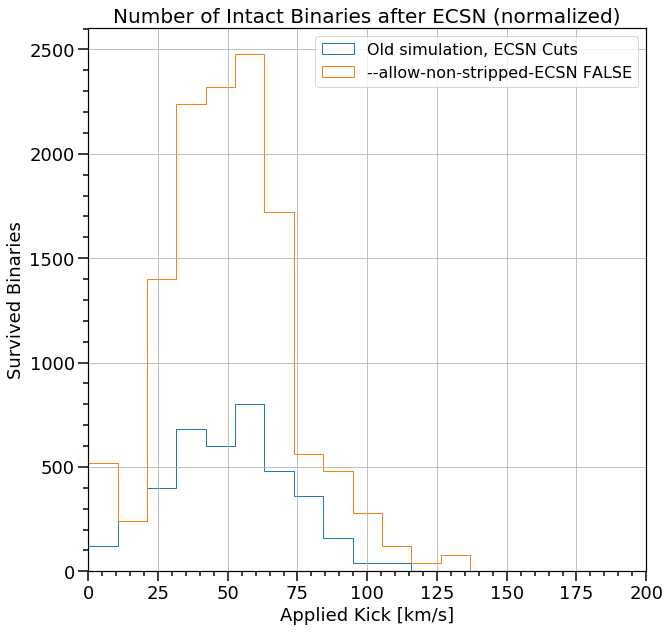

In [42]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 200, 20)

plt.hist(APPLIED_KICKS_ECSN_BOUND_ECSN_FALSE, bins=bins, density=False, histtype='step', label='Old simulation, ECSN Cuts')
plt.hist(APPLIED_KICKS_ECSN_BOUND, bins=bins, density=False, histtype='step', label='--allow-non-stripped-ECSN FALSE')



plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survived Binaries')

plt.title("Number of Intact Binaries after ECSN (normalized)", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


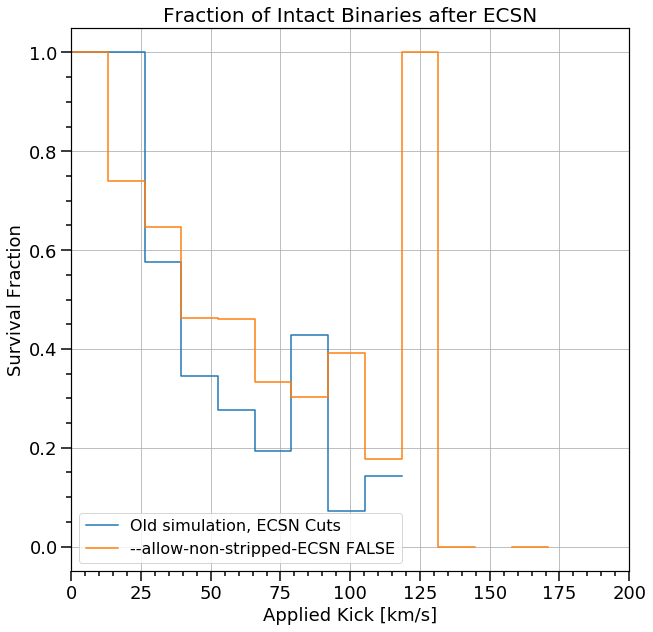

In [43]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 250, 20)

survived_manual, bins = np.histogram(APPLIED_KICKS_ECSN_BOUND_ECSN_FALSE, bins=bins)
survived_non_stripped, bins = np.histogram(APPLIED_KICKS_ECSN_BOUND, bins=bins)

total_manual, bins = np.histogram(APPLIED_KICKS_ECSN_ECSN_FALSE, bins=bins)
total_non_stripped, bins = np.histogram(APPLIED_KICKS_ECSN, bins=bins)

plt.step(bins[:-1], survived_manual/total_manual, where='post', label='Old simulation, ECSN Cuts')
plt.step(bins[:-1], survived_non_stripped/total_non_stripped, where='post', label='--allow-non-stripped-ECSN FALSE')



plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

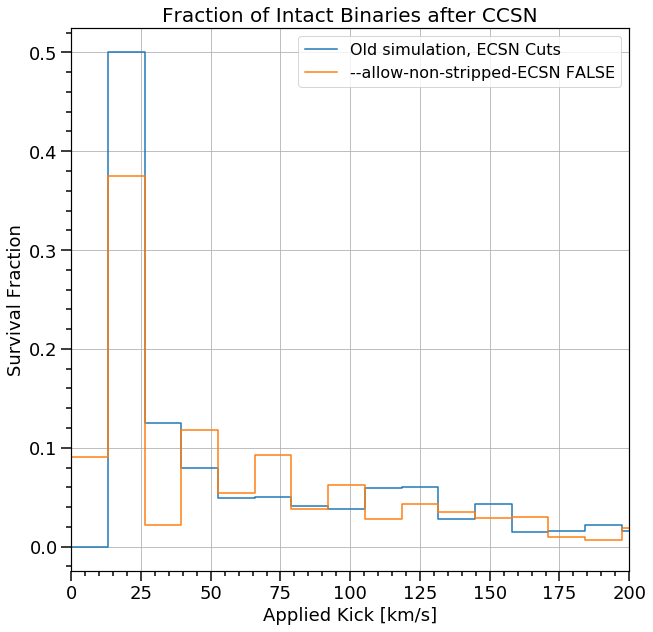

In [44]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 250, 20)

survived_manual, bins = np.histogram(APPLIED_KICKS_CCSN_BOUND_ECSN_FALSE, bins=bins)
survived_non_stripped, bins = np.histogram(APPLIED_KICKS_CCSN_BOUND, bins=bins)

total_manual, bins = np.histogram(APPLIED_KICKS_CCSN_ECSN_FALSE, bins=bins)
total_non_stripped, bins = np.histogram(APPLIED_KICKS_CCSN, bins=bins)

plt.step(bins[:-1], survived_manual/total_manual, where='post', label='Old simulation, ECSN Cuts')
plt.step(bins[:-1], survived_non_stripped/total_non_stripped, where='post', label='--allow-non-stripped-ECSN FALSE')



plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after CCSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

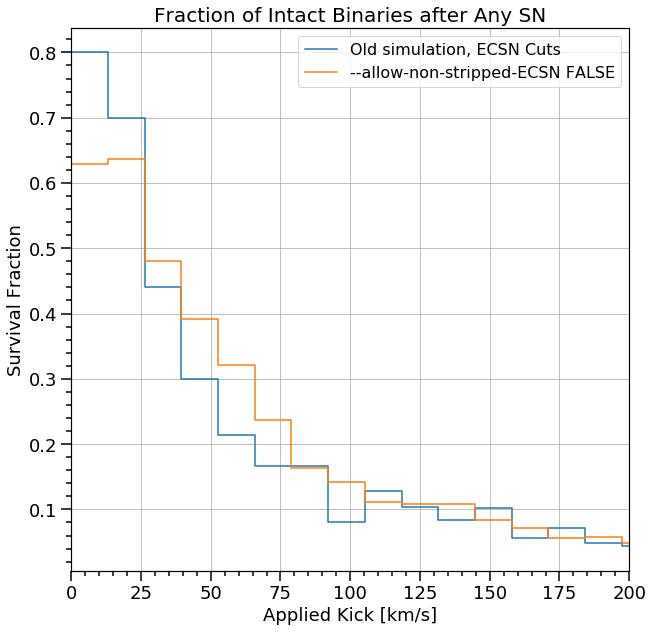

In [45]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 250, 20)

survived_manual, bins = np.histogram(APPLIED_KICKS_ALLSN_BOUND_ECSN_FALSE, bins=bins)
survived_non_stripped, bins = np.histogram(APPLIED_KICKS_ALLSN_BOUND, bins=bins)

total_manual, bins = np.histogram(APPLIED_KICKS_ALLSN_ECSN_FALSE, bins=bins)
total_non_stripped, bins = np.histogram(APPLIED_KICKS_ALLSN, bins=bins)

plt.step(bins[:-1], survived_manual/total_manual, where='post', label='Old simulation, ECSN Cuts')
plt.step(bins[:-1], survived_non_stripped/total_non_stripped, where='post', label='--allow-non-stripped-ECSN FALSE')



plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after Any SN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

# See why the ECSN kicks are so large

In [4]:
ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigma = 0.3

ECSN_list = []
ECSN_bound_list = []
ALLSN_list = []


for vns in ns_kicks:
    path = os.environ['WORK']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'
    fdata_bse = h5.File(path, 'r')

    SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
    SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
    KICK_DATA = fdata_bse['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
    UNBOUND = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 
    SMA_PRE_SN = fdata_bse['BSE_Supernovae']["SemiMajorAxis<SN"][...].squeeze() 

    ECSN = KICK_DATA[(SN_STELLAR_TYPE ==13) * (SN_TYPE == 2) * (SMA_PRE_SN > 0)] 
    ECSN_list.append(ECSN)
    
    ECSN_BOUND = KICK_DATA[(SN_STELLAR_TYPE ==13) * (SN_TYPE == 2) * (UNBOUND == 0) * (SMA_PRE_SN > 0)]
    ECSN_bound_list.append(ECSN_BOUND)
    
    ALLSN = KICK_DATA[((SN_STELLAR_TYPE ==13))] 
    ALLSN_list.append(ALLSN)
    fdata_bse.close()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


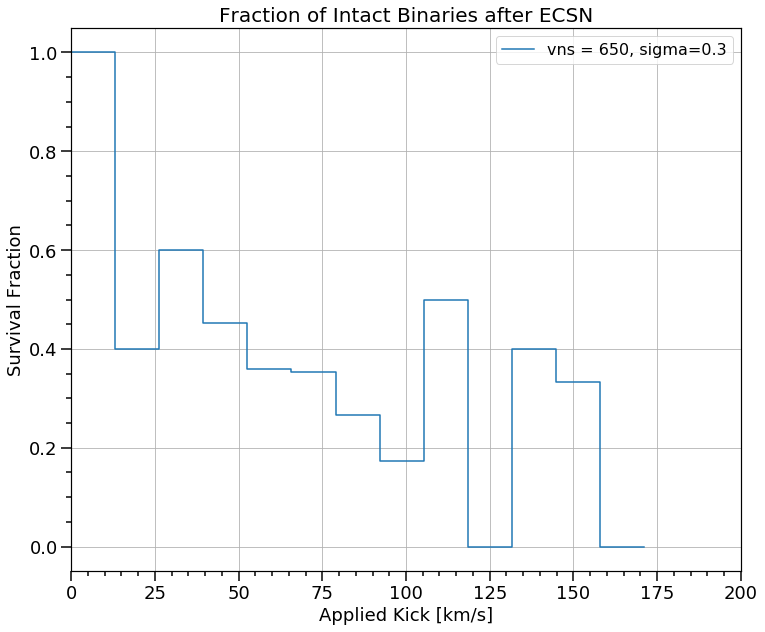

In [6]:
f, ax= plt.subplots(1, 1,  figsize=(12,10)) 

bins = np.linspace(0, 250, 20)

for i in [7]:
# for i in range(len(ns_kicks)):
    survived, bins = np.histogram(ECSN_bound_list[i], bins=bins)
    total, bins = np.histogram(ECSN_list[i], bins=bins)
    plt.step(bins[:-1], survived/total, where='post', label=f"vns = {ns_kicks[i]}, sigma=0.3")

    for j in range(5, len(survived)):
        perc = survived[j]/total[j]
        if  perc > 0.5:
            print(f"\nFor vns={ns_kicks[i]}, in ECSN Kick bin={bins[j]:.2f} km/s: \n\t{survived[j]} survived out of {total[j]} kicks ({perc*100:.2f}%)")
            print(f"\tThis is {100*survived[j]/sum(total):.2f}% of all ECSN systems")


plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


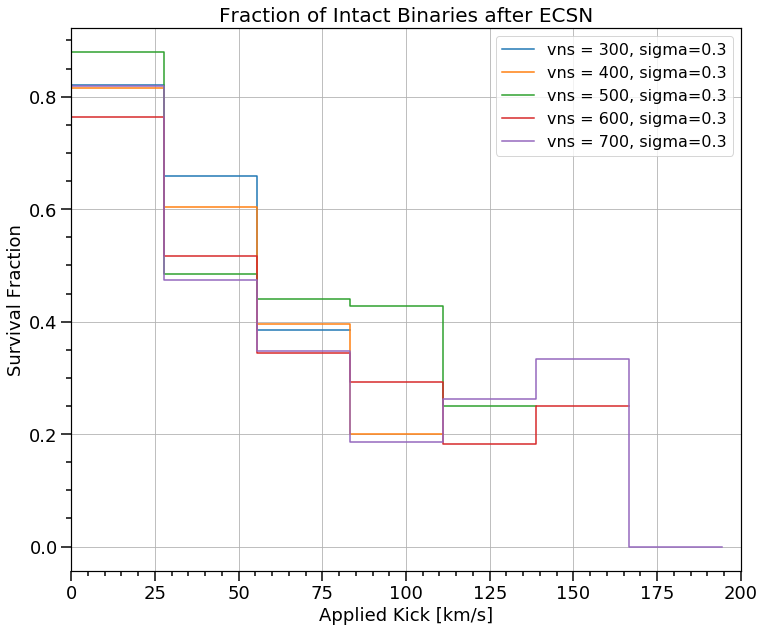

In [27]:
f, ax= plt.subplots(1, 1,  figsize=(12,10)) 

bins = np.linspace(0, 250, 10)

for i in [0,2,4,6,8]:
# for i in range(len(ns_kicks)):
    survived, bins = np.histogram(ECSN_bound_list[i], bins=bins)
    total, bins = np.histogram(ECSN_list[i], bins=bins)
    plt.step(bins[:-1], survived/total, where='post', label=f"vns = {ns_kicks[i]}, sigma=0.3")

    for j in range(5, len(survived)):
        perc = survived[j]/total[j]
        if  perc > 0.5:
            print(f"For vns={ns_kicks[i]}, ECSN Kick={bins[j]:.2f} km/s: {survived[j]} survived out of {total[j]} kicks ({perc*100:.2f}%)")
            print(f"  This is {100*survived[j]/sum(total):.2f}% of all ECSN systems")
            


plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

In [16]:
path = os.environ['WORK']+f'/supernova_remnant_det/hobbs_detection_1e7_0.h5'
fdata_bse = h5.File(path, 'r')

SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
KICK_DATA = fdata_bse['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
UNBOUND = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 

ECSN_hobbs = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2))] 
ECSN_BOUND_hobbs = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2)) * (UNBOUND == 0)]
ALLSN_hobbs = KICK_DATA[((SN_STELLAR_TYPE ==13))] 
fdata_bse.close()


/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


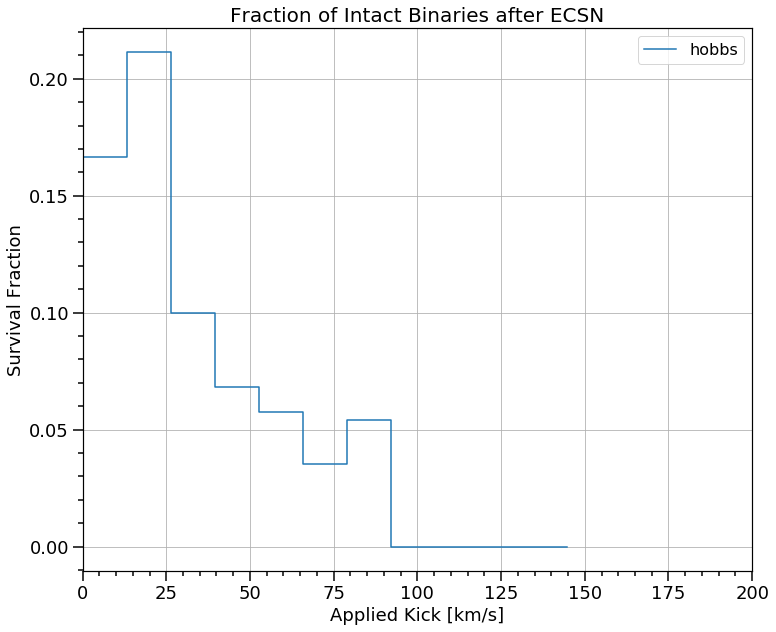

In [17]:
f, ax= plt.subplots(1, 1,  figsize=(12,10)) 
bins = np.linspace(0, 250, 20)

survived, bins = np.histogram(ECSN_BOUND_hobbs, bins=bins)
total, bins = np.histogram(ECSN_hobbs, bins=bins)
plt.step(bins[:-1], survived/total, where='post', label=f"hobbs")

plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

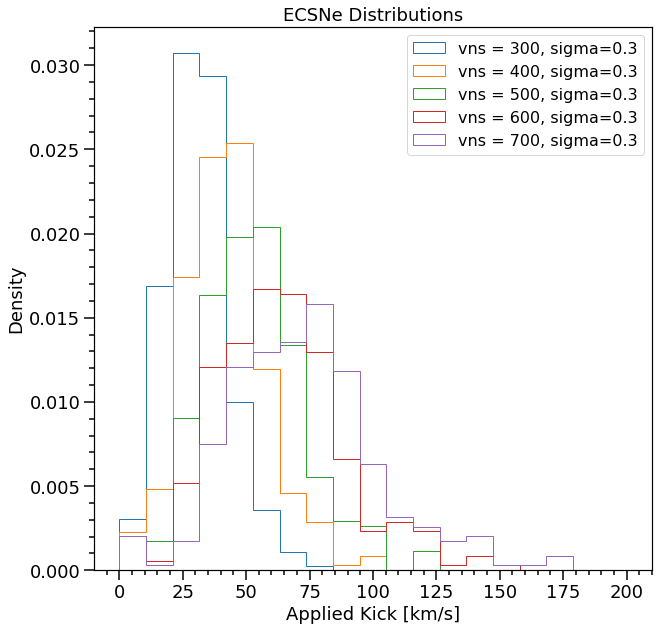

In [6]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

bins = np.linspace(0, 200, 20)

for i in [0,2,4,6,8]:
    plt.hist(ECSN_list[i], bins=bins, label=f"vns = {ns_kicks[i]}, sigma=0.3", histtype='step', density=True)

plt.legend(fontsize=16)
plt.title('ECSNe Distributions', fontsize=18)
layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Density')

plt.show()

In [7]:
max_v = np.zeros(len(ns_kicks))
for i in range(len(max_v)):
    max_v[i] = np.max(ECSN_list[i])

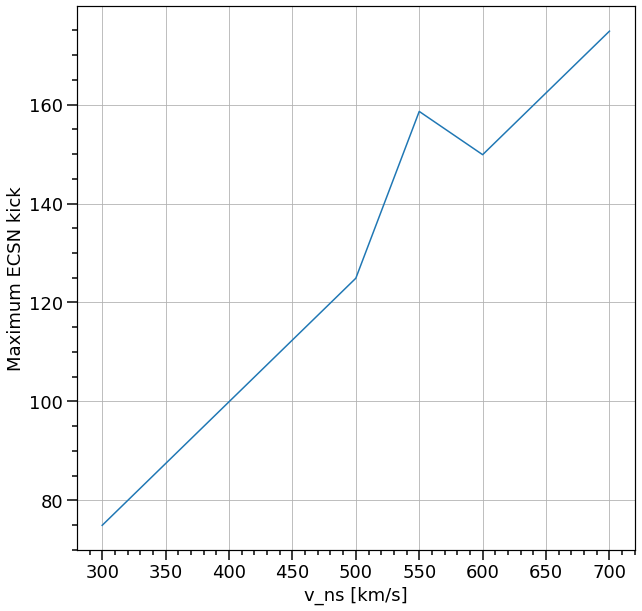

In [8]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

plt.plot(ns_kicks, max_v)
layoutAxes(ax=ax, nameX='v_ns [km/s]',\
       nameY='Maximum ECSN kick')
plt.grid()
plt.show()

In [76]:
# Try Applying MT Donor Cut

ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigma = 0.3

ECSN_list = []
ECSN_bound_list = []
ALLSN_list = []


for vns in ns_kicks:
    path = os.environ['WORK']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'
    fdata_bse = h5.File(path, 'r')

    print(vns)
    
    SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
    SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
    KICK_DATA = fdata_bse['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
    UNBOUND = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 

    
    MT_DONOR_HIST = fdata_bse['BSE_Supernovae']["MT_Donor_Hist(SN)"][...].squeeze()
    MT_DONOR_HIST = list(map(lambda x: x.decode('utf-8'), MT_DONOR_HIST))
    MT_DONOR_MASK = np.full(len(MT_DONOR_HIST), True, dtype="bool")

    indices = []
    for i in range(len(MT_DONOR_HIST)):
        if SN_TYPE[i]==2:
            MT_DONOR_MASK[i] = bool("NA" not in MT_DONOR_HIST[i])
            if ("NA" in MT_DONOR_HIST[i]):
                print("found accretor")
            
                
                
    ECSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2) * MT_DONOR_MASK)] 
    ECSN_list.append(ECSN)
    
    ECSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2) * (UNBOUND == 0) * MT_DONOR_MASK)]
    ECSN_bound_list.append(ECSN_BOUND)
    
    ALLSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * MT_DONOR_MASK)] 
    ALLSN_list.append(ALLSN)
    
    fdata_bse.close()

300
350
400
450
500
550
600
650
700


/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


For vns=400, ECSN Kick=65.79 km/s: 320 survived out of 560 kicks (57.14%)
For vns=500, ECSN Kick=78.95 km/s: 360 survived out of 680 kicks (52.94%)
For vns=500, ECSN Kick=105.26 km/s: 40 survived out of 40 kicks (100.00%)
For vns=600, ECSN Kick=131.58 km/s: 80 survived out of 120 kicks (66.67%)


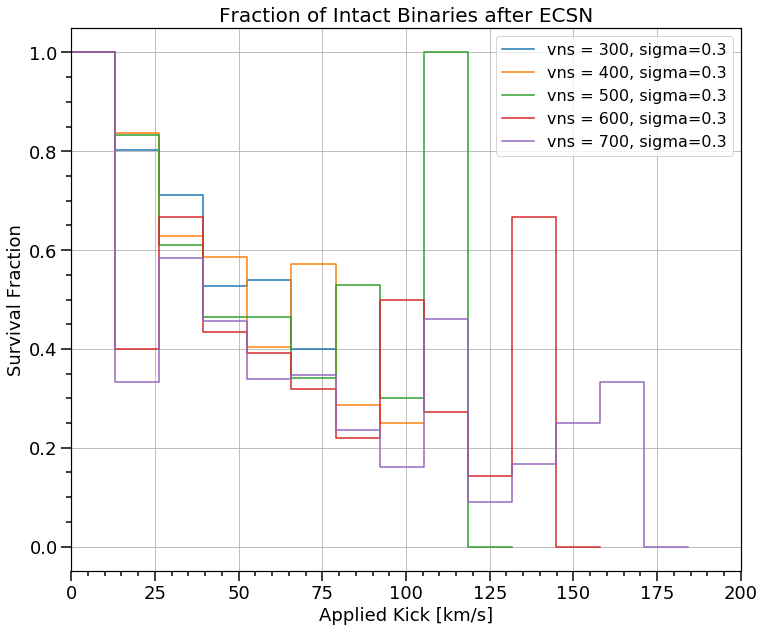

In [77]:
f, ax= plt.subplots(1, 1,  figsize=(12,10)) 

bins = np.linspace(0, 250, 20)

for i in [0,2,4,6,8]:
# for i in range(len(ns_kicks)):
    survived, bins = np.histogram(ECSN_bound_list[i], bins=bins)
    total, bins = np.histogram(ECSN_list[i], bins=bins)
    plt.step(bins[:-1], survived/total, where='post', label=f"vns = {ns_kicks[i]}, sigma=0.3")

    for j in range(5, len(survived)):
        perc = survived[j]/total[j]
        if  perc > 0.5:
            print(f"For vns={ns_kicks[i]}, ECSN Kick={bins[j]:.2f} km/s: {survived[j]} survived out of {total[j]} kicks ({perc*100:.2f}%)")
            


plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

# New Reseeded simulations

In [61]:
vns = 550
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

ECSN_list = []
ECSN_bound_list = []
ALLSN_list = []

for sigma in sigmas:
    path = os.environ['SCRATCH']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'

    fdata_bse = h5.File(path, 'r')

    SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
    SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
    KICK_DATA = fdata_bse['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
    UNBOUND = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 
    SMA_PRE_SN = fdata_bse['BSE_Supernovae']["SemiMajorAxis<SN"][...].squeeze() 

    ECSN = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2))] 
    ECSN_list.append(ECSN)
    
    ECSN_BOUND = KICK_DATA[((SN_STELLAR_TYPE ==13) * (SN_TYPE == 2) * (UNBOUND == 0))]
    ECSN_bound_list.append(ECSN_BOUND)
    
    ALLSN = KICK_DATA[((SN_STELLAR_TYPE ==13))] 
    ALLSN_list.append(ALLSN) 

    fdata_bse.close()

In [64]:
# check if the unique seed trick worked
for sigma in sigmas:
    print(f"{vns}, {sigma}")
    path = os.environ['SCRATCH']+f'/supernova_remnant_bse_production/bh_200_ns_{vns}_sigma_{sigma}_combined.h5'
    fdata_bse = h5.File(path, 'r')
    SEED = fdata_bse['BSE_System_Parameters']["SEED"][...].squeeze() 
    fdata_bse.close()
    unique, counts = np.unique(SEED, return_counts=True)
    print(len(SEED))
    print(len(unique))
    print()
    


550, 0.1
1000048
1000048

550, 0.2
1000048
1000048

550, 0.3
1035764
1000048

550, 0.4
1000048
1000048

550, 0.5
1178628
1000048



/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


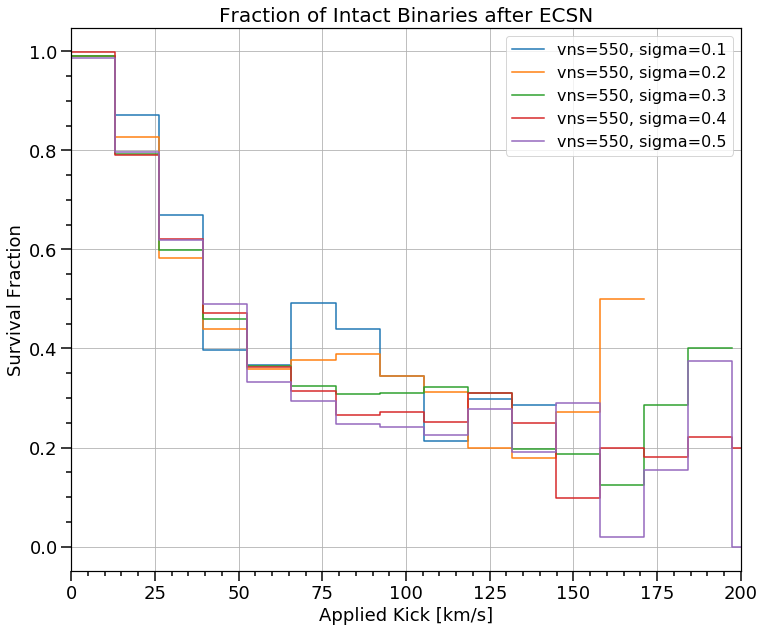

In [67]:
f, ax= plt.subplots(1, 1,  figsize=(12,10)) 

bins = np.linspace(0, 250, 20)


for i in range(len(sigmas)):
    survived, bins = np.histogram(ECSN_bound_list[i], bins=bins)
    total, bins = np.histogram(ECSN_list[i], bins=bins)
    plt.step(bins[:-1], survived/total, where='post', label=f"vns={vns}, sigma={sigmas[i]}")

plt.xlim(0,200)

layoutAxes(ax=ax, nameX='Applied Kick [km/s]',\
       nameY='Survival Fraction')

plt.title("Fraction of Intact Binaries after ECSN", fontsize=20)
plt.legend(fontsize=16)

plt.grid()
plt.show()

Issue solved!